In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
import numpy as np
import re
import json

In [2]:
endpoint = "https://skynet.coypu.org/qald-x-analysis/"

In [3]:
def KB_query(query, kb_endpoint):
    sparql = SPARQLWrapper(kb_endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    response = sparql.query().convert()
    results = parse_query_results(response)
    return results

In [4]:
def parse_query_results(response):
    if "boolean" in response: # ASK
        results = [response["boolean"]]
    else:
        if len(response["results"]["bindings"]) > 0 and "callret-0" in response["results"]["bindings"][0]: # COUNT
            results = [response["results"]["bindings"][0]["callret-0"]["value"]]
        else:
            results = []
            for res in response["results"]["bindings"]:
                res = {k: v["value"] for k, v in res.items()}
                results.append(res)
    return results

In [5]:
def reconstruct_query(named_graph_uri, query):
    where_start_idx = query.find("WHERE")
    if where_start_idx < 0:
        print("The keyword WHERE can not be found in query: ", query)
    new_query = query[:where_start_idx] + "FROM " + named_graph_uri + " " + query[where_start_idx:]
    return new_query

In [6]:
# get the distribution of the number of triple patterns

def get_dist_triple_patterns(named_graph_uri):
    orig_query = "SELECT ?tp WHERE { ?s <http://lsq.aksw.org/vocab#text> ?text . ?s <http://lsq.aksw.org/vocab#hasStructuralFeatures> ?sf . ?sf <http://lsq.aksw.org/vocab#tpCount> ?tp. }"
    TP_query = reconstruct_query(named_graph_uri, orig_query)
    TP = KB_query(TP_query, endpoint)
    TP = [float(a["tp"]) for a in TP]
    return TP

def get_dist_joins(named_graph_uri):
    orig_query = "SELECT ?jv WHERE { ?s <http://lsq.aksw.org/vocab#text> ?text . ?s <http://lsq.aksw.org/vocab#hasStructuralFeatures> ?sf . ?sf <http://lsq.aksw.org/vocab#joinVertexCount> ?jv. }"
    Joins_query = reconstruct_query(named_graph_uri, orig_query)
    Joins = KB_query(Joins_query, endpoint)
    Joins = [float(a["jv"]) for a in Joins]
    return Joins

def get_dist_funcs(named_graph_uri):
    orig_query = "SELECT (count(DISTINCT ?text) as ?totalFunc) WHERE { ?s <http://lsq.aksw.org/vocab#text> ?text . ?s <http://lsq.aksw.org/vocab#hasStructuralFeatures> ?sf . ?sf <http://lsq.aksw.org/vocab#usesFeature>  <http://lsq.aksw.org/vocab#Functions> }"
    Funcs_query = reconstruct_query(named_graph_uri, orig_query)
    Funcs = KB_query(Funcs_query, endpoint)
    totalFunc = int(Funcs[0]["totalFunc"])
    return totalFunc

def get_dist_jvd(named_graph_uri):
    orig_query = "SELECT ?jvd WHERE { ?s <http://lsq.aksw.org/vocab#text> ?text . ?s <http://lsq.aksw.org/vocab#hasStructuralFeatures> ?sf . ?sf <http://lsq.aksw.org/vocab#joinVertexDegreeMean> ?jvd. }"
    JVD_query = reconstruct_query(named_graph_uri, orig_query)
    JVD = KB_query(JVD_query, endpoint)
    JVD = [float(a["jvd"]) for a in JVD]
    return JVD

def get_solution_modifiers(named_graph_uri):
    orig_query = "SELECT (count(DISTINCT ?text) as ?totalMod) WHERE { ?s <http://lsq.aksw.org/vocab#text> ?text . ?s <http://lsq.aksw.org/vocab#hasStructuralFeatures> ?sf . ?sf <http://lsq.aksw.org/vocab#usesFeature> ?uf . FILTER(?uf = <http://lsq.aksw.org/vocab#OrderBy> || ?uf = <http://lsq.aksw.org/vocab#Offset> || ?uf = <http://lsq.aksw.org/vocab#Limit>) }"
    totalMod_query = reconstruct_query(named_graph_uri, orig_query)
    totalMod = KB_query(totalMod_query, endpoint)

def get_ask_frequency(named_graph_uri):
    orig_query = "SELECT (count(DISTINCT ?text) as ?Ask) WHERE { ?s <http://lsq.aksw.org/vocab#text> ?text . ?s <http://lsq.aksw.org/vocab#hasSpin> ?spin . ?spin a <http://spinrdf.org/sp#Ask> . }"
    Ask_query = reconstruct_query(named_graph_uri, orig_query)
    Ask_freq = KB_query(Ask_query, endpoint)
    Ask_freq = int(Ask_freq[0]["Ask"])
    return Ask_freq

def get_limit_frequency(named_graph_uri):
    orig_query = "SELECT (count(DISTINCT ?text) as ?totalLimit) WHERE { ?s <http://lsq.aksw.org/vocab#text> ?text . ?s <http://lsq.aksw.org/vocab#hasStructuralFeatures> ?sf . ?sf <http://lsq.aksw.org/vocab#usesFeature> <http://lsq.aksw.org/vocab#Limit> . }"
    Limit_query = reconstruct_query(named_graph_uri, orig_query)
    Limit_freq = KB_query(Limit_query, endpoint)
    Limit_freq = int(Limit_freq[0]["totalLimit"])
    return Limit_freq

def get_orderby_frequency(named_graph_uri):
    orig_query = "SELECT (count(DISTINCT ?text) as ?totalOrderBy) WHERE { ?s <http://lsq.aksw.org/vocab#text> ?text . ?s <http://lsq.aksw.org/vocab#hasStructuralFeatures> ?sf . ?sf <http://lsq.aksw.org/vocab#usesFeature> <http://lsq.aksw.org/vocab#OrderBy> . }"
    Orderby_query = reconstruct_query(named_graph_uri, orig_query)
    Orderby_freq = KB_query(Orderby_query, endpoint)
    Orderby_freq = int(Orderby_freq[0]["totalOrderBy"])
    return Orderby_freq

def get_filter_frequency(named_graph_uri):
    orig_query = "SELECT (count(DISTINCT ?text) as ?totalFilter) WHERE { ?s <http://lsq.aksw.org/vocab#text> ?text . ?s <http://lsq.aksw.org/vocab#hasStructuralFeatures> ?sf . ?sf <http://lsq.aksw.org/vocab#usesFeature> <http://lsq.aksw.org/vocab#Filter> . }"
    Filter_query = reconstruct_query(named_graph_uri, orig_query)
    Filter_freq = KB_query(Filter_query, endpoint)
    Filter_freq = int(Filter_freq[0]["totalFilter"])
    return Filter_freq


def get_union_frequency(named_graph_uri):
    orig_query = "SELECT (count(DISTINCT ?text) as ?totalUnion) WHERE { ?s <http://lsq.aksw.org/vocab#text> ?text . ?s <http://lsq.aksw.org/vocab#hasStructuralFeatures> ?sf . ?sf <http://lsq.aksw.org/vocab#usesFeature> <http://lsq.aksw.org/vocab#Union> . }"
    Union_query = reconstruct_query(named_graph_uri, orig_query)
    Union_freq = KB_query(Union_query, endpoint)
    Union_freq = int(Union_freq[0]["totalUnion"])
    return Union_freq


def get_offset_frequency(named_graph_uri):
    orig_query = "SELECT (count(DISTINCT ?text) as ?totalOffset) WHERE { ?s <http://lsq.aksw.org/vocab#text> ?text . ?s <http://lsq.aksw.org/vocab#hasStructuralFeatures> ?sf . ?sf <http://lsq.aksw.org/vocab#usesFeature> <http://lsq.aksw.org/vocab#Offset> . }"
    Offset_query = reconstruct_query(named_graph_uri, orig_query)
    Offset_freq = KB_query(Offset_query, endpoint)
    Offset_freq = int(Offset_freq[0]["totalOffset"])
    return Offset_freq

def get_groupby_frequency(named_graph_uri):
    orig_query = "SELECT (count(DISTINCT ?text) as ?totalGroupBy) WHERE { ?s <http://lsq.aksw.org/vocab#text> ?text . ?s <http://lsq.aksw.org/vocab#hasStructuralFeatures> ?sf . ?sf <http://lsq.aksw.org/vocab#usesFeature> <http://lsq.aksw.org/vocab#GroupBy> .}"
    Groupby_query = reconstruct_query(named_graph_uri, orig_query)
    Groupby_freq = KB_query(Groupby_query, endpoint)
    Groupby_freq = int(Groupby_freq[0]["totalGroupBy"])
    return Groupby_freq


def calculate_variance(dist):
    mean = np.mean(np.array(dist))
    std = np.std(np.array(dist))
    variance = np.var(np.array(dist))
    return mean, std, variance

In [7]:
def calculate_diversity_score(tp_mean_sd, joins_mean_sd, jvd_mean_sd):
    diversity = 1 / 3 * (tp_mean_sd[1]/tp_mean_sd[0] + joins_mean_sd[1]/joins_mean_sd[0] + jvd_mean_sd[1]/jvd_mean_sd[0])
    return diversity

In [8]:
# get frequencies of each modifier obtained from the sparql queries
count_pattern = re.compile('count|COUNT')
having_pattern = re.compile('having|HAVING')
year_pattern = re.compile('year|YEAR')
now_pattern = re.compile('now|NOW')

def get_frequencies_modifiers(data, named_graph_uri):
    counts, limits, order_by, filters, asks, unions, offsets, group_by, havings, years, nows = 0,0,0,0,0,0,0,0,0,0,0
    for datum in data:
        counts += len(re.findall(count_pattern, datum))
        havings += len(re.findall(having_pattern, datum))
        years += len(re.findall(year_pattern, datum))
        nows += len(re.findall(now_pattern, datum))

    limits = get_limit_frequency(named_graph_uri)
    order_by = get_orderby_frequency(named_graph_uri)
    filters = get_filter_frequency(named_graph_uri)
    asks = get_ask_frequency(named_graph_uri)
    unions = get_union_frequency(named_graph_uri)
    offsets = get_offset_frequency(named_graph_uri)
    group_by = get_groupby_frequency(named_graph_uri)

    return counts, limits, order_by, filters, asks, unions, offsets, group_by, havings, years, nows


# QALD-10-Wikidata-Test

In [9]:
dist_triple_patterns_qald10_wikidata_test=get_dist_triple_patterns("<http://lsq.aksw.org/graph#qald10-wikidata-test>")
print(dist_triple_patterns_qald10_wikidata_test, sep="\t")

[1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 6.0, 1.0, 1.0, 3.0, 3.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 3.0, 1.0, 1.0, 1.0, 4.0, 3.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 3.0, 1.0, 1.0, 1.0, 0.0, 3.0, 1.0, 0.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 4.0, 4.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 5.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 3.0, 0.0, 4.0, 1.0, 3.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 5.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 3.0, 2.0, 1.0, 2.0, 3.0, 2.0, 3.0, 4.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 2.0, 3.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 3.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 6.0, 2.0, 1.0, 2.0, 1.0, 3.0, 0.0, 0.0, 6.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0,

In [10]:
mean_tp_qald10_wd_test, std_tp_qald10_wd_test, var_tp_qald10_wd_test = calculate_variance(dist_triple_patterns_qald10_wikidata_test)
print("Mean: {0}, Std: {1}, Variance: {2}".format(mean_tp_qald10_wd_test, std_tp_qald10_wd_test, var_tp_qald10_wd_test))

Mean: 1.6045918367346939, Std: 1.1991831134256343, Variance: 1.4380401395251978


In [11]:
dist_joins_qald10_wikidata_test=get_dist_joins("<http://lsq.aksw.org/graph#qald10-wikidata-test>")
print(dist_joins_qald10_wikidata_test, sep="\t")

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 6.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 6.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 4.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 6.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,

In [12]:
mean_joins_qald10_wd_test, std_joins_qald10_wd_test, var_joins_qald10_wd_test = calculate_variance(dist_joins_qald10_wikidata_test)
print("Mean: {0}, Std: {1}, Variance: {2}".format(mean_joins_qald10_wd_test, std_joins_qald10_wd_test, var_joins_qald10_wd_test))

Mean: 0.6224489795918368, Std: 1.1227272382366746, Variance: 1.2605164514785507


In [13]:
dist_jvd_qald10_wikidata_test=get_dist_jvd("<http://lsq.aksw.org/graph#qald10-wikidata-test>")
print(dist_jvd_qald10_wikidata_test, sep="\t")

[0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 2.3333333334, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 4.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 3.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 2.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.6666666667, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 3.0, 0.0, 2.5, 0.0, 3.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 3.0, 2.0, 0.0, 0.0, 3.0, 2.0, 2.5, 2.25, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.5, 2.0, 3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 3.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.3333333334, 2.0, 0.0, 2.0, 0.0, 3.0, 0.0, 0.0, 2.3333

In [14]:
mean_jvd_qald10_wd_test, std_jvd_qald10_wd_test, var_jvd_qald10_wd_test = calculate_variance(dist_jvd_qald10_wikidata_test)
print("Mean: {0}, Std: {1}, Variance: {2}".format(mean_jvd_qald10_wd_test, std_jvd_qald10_wd_test, var_jvd_qald10_wd_test))

Mean: 0.8894740038887755, Std: 1.1333879173018446, Variance: 1.2845681710858128


In [15]:
totalFuncs_qald10_wd_test = get_dist_funcs("<http://lsq.aksw.org/graph#qald10-wikidata-test>")
print("Total queries having functions: ", totalFuncs_qald10_wd_test)

Total queries having functions:  74


In [16]:
qald10_wd_test = json.load(open("../data/qald_10/qald_10.json"))
qald10_wd_test_sparqls = [question["query"]["sparql"] for question in qald10_wd_test["questions"]]

In [17]:
counts, limits, order_by, filters, asks, unions, offsets, group_by, havings, years, nows = get_frequencies_modifiers(qald10_wd_test_sparqls, "<http://lsq.aksw.org/graph#qald10-wikidata-test>")

print("Frequency of each modifier\nCOUNT: {0}\nLIMIT: {1}\nORDER BY: {2}\nFILTER: {3}\nASK: {4}\nUNION: {5}\nOFFSET: {6}\nGROUP BY: {7}\nHAVING: {8}\nYEAR: {9}\nNOW: {10}\n".format(counts, limits, order_by, filters, asks, unions, offsets, group_by, havings, years, nows))

Frequency of each modifier
COUNT: 126
LIMIT: 17
ORDER BY: 17
FILTER: 74
ASK: 60
UNION: 5
OFFSET: 3
GROUP BY: 95
HAVING: 1
YEAR: 43
NOW: 1



In [18]:
# Calculate Diversity Score
diversity_qald10_wd_test = calculate_diversity_score([mean_tp_qald10_wd_test, std_tp_qald10_wd_test], [mean_joins_qald10_wd_test, std_joins_qald10_wd_test], [mean_jvd_qald10_wd_test, std_jvd_qald10_wd_test])
print("Diversity Score of QALD-10 Test set: ", diversity_qald10_wd_test)

Diversity Score of QALD-10 Test set:  1.275097671454253


# QALD9-Plus-dbpedia-Train

In [19]:
dist_triple_patterns_qald9_dbpedia_train=get_dist_triple_patterns("<http://lsq.aksw.org/graph#qald9-plus-dbpedia-train>")
print(dist_triple_patterns_qald9_dbpedia_train, sep="\t")

[4.0, 4.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 4.0, 3.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 3.0, 2.0, 1.0, 1.0, 2.0, 3.0, 1.0, 1.0, 2.0, 5.0, 1.0, 1.0, 2.0, 1.0, 1.0, 3.0, 2.0, 1.0, 3.0, 1.0, 1.0, 4.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 3.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 3.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 3.0, 1.0, 1.0, 1.0, 3.0, 2.0, 2.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0, 1.0, 2.0, 3.0, 1.0, 1.0, 2.0, 1.0, 3.0, 1.0, 1.0, 1.0, 2.0, 3.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 3.0, 3.0, 1.0, 4.0, 2.0, 4.0, 2.0, 1.0, 3.0, 1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 3.0, 2.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 2.0, 1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 4.0, 3.0, 3.0, 5.0, 1.0, 1.0, 1.0, 2.0, 5.0, 1.0, 1.0, 1.0, 3.0, 2.0, 1.0, 3.0, 1.0, 1.0, 4.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 1.0, 4.0, 1.0,

In [20]:
mean_tp_qald9_dbpedia_train, std_tp_qald9_dbpedia_train, var_tp_qald9_dbpedia_train = calculate_variance(dist_triple_patterns_qald9_dbpedia_train)
print("Mean: {0}, Std: {1}, Variance: {2}".format(mean_tp_qald9_dbpedia_train, std_tp_qald9_dbpedia_train, var_tp_qald9_dbpedia_train))

Mean: 1.727735368956743, Std: 0.943529841082765, Variance: 0.8902485610136679


In [21]:
dist_joins_qald9_dbpedia_train=get_dist_joins("<http://lsq.aksw.org/graph#qald9-plus-dbpedia-train>")
print(dist_joins_qald9_dbpedia_train, sep="\t")

[3.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 3.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 3.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 3.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,

In [22]:
mean_joins_qald9_dbpedia_train, std_joins_qald9_dbpedia_train, var_joins_qald9_dbpedia_train = calculate_variance(dist_joins_qald9_dbpedia_train)
print("Mean: {0}, Std: {1}, Variance: {2}".format(mean_joins_qald9_dbpedia_train, std_joins_qald9_dbpedia_train, var_joins_qald9_dbpedia_train))

Mean: 0.5089058524173028, Std: 0.6619787392259084, Variance: 0.43821585118712325


In [23]:
dist_jvd_qald9_dbpedia_train=get_dist_jvd("<http://lsq.aksw.org/graph#qald9-plus-dbpedia-train>")
print(dist_jvd_qald9_dbpedia_train, sep="\t")

[2.3333333334, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 3.0, 2.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 3.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 3.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 3.0, 2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, 2.0, 3.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 3.0, 2.0, 0.0, 2.0, 3.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0, 3.0, 2.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.6666666667, 0.0, 0.0, 0.0, 3.0, 2.0, 0.0, 3.0, 0.0, 0.0, 2.3333333334, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.

In [24]:
mean_jvd_qald9_dbpedia_train, std_jvd_qald9_dbpedia_train, var_jvd_qald9_dbpedia_train = calculate_variance(dist_jvd_qald9_dbpedia_train)
print("Mean: {0}, Std: {1}, Variance: {2}".format(mean_jvd_qald9_dbpedia_train, std_jvd_qald9_dbpedia_train, var_jvd_qald9_dbpedia_train))

Mean: 0.9410517387620865, Std: 1.1134359842993444, Variance: 1.23973969113265


In [25]:
totalFuncs_qald9_dbpeida_train = get_dist_funcs("<http://lsq.aksw.org/graph#qald9-plus-dbpedia-train>")
print("Total queries having functions: ", totalFuncs_qald9_dbpeida_train)

Total queries having functions:  31


In [26]:
qald9_dbpedia_train = json.load(open("/Users/longquan/Documents/OSS/QALD_9_plus/data/qald_9_plus_train_dbpedia.json"))
qald9_dbpedia_train_sparqls = [question["query"]["sparql"] for question in qald9_dbpedia_train["questions"]]

In [27]:
counts, limits, order_by, filters, asks, unions, offsets, group_by, havings, years, nows = get_frequencies_modifiers(qald9_dbpedia_train_sparqls, "<http://lsq.aksw.org/graph#qald9-plus-dbpedia-train>")

print("Frequency of each modifier\nCOUNT: {0}\nLIMIT: {1}\nORDER BY: {2}\nFILTER: {3}\nASK: {4}\nUNION: {5}\nOFFSET: {6}\nGROUP BY: {7}\nHAVING: {8}\nYEAR: {9}\nNOW: {10}\n".format(counts, limits, order_by, filters, asks, unions, offsets, group_by, havings, years, nows))

Frequency of each modifier
COUNT: 57
LIMIT: 39
ORDER BY: 36
FILTER: 31
ASK: 37
UNION: 29
OFFSET: 1
GROUP BY: 19
HAVING: 3
YEAR: 6
NOW: 3



In [28]:
# Calculate Diversity Score
diversity_qald9_dbpedia_train = calculate_diversity_score([mean_tp_qald9_dbpedia_train, std_tp_qald9_dbpedia_train], [mean_joins_qald9_dbpedia_train, std_joins_qald9_dbpedia_train], [mean_jvd_qald9_dbpedia_train, std_jvd_qald9_dbpedia_train])
print("Diversity Score of QALD-9-Plus DBpedia Train set: ", diversity_qald9_dbpedia_train)

Diversity Score of QALD-9-Plus DBpedia Train set:  1.010026202120737


# QALD9-Plus-dbpedia-Test

In [29]:
dist_triple_patterns_qald9_dbpedia_test=get_dist_triple_patterns("<http://lsq.aksw.org/graph#qald9-plus-dbpedia-test>")
print(dist_triple_patterns_qald9_dbpedia_test, sep="\t")

[3.0, 3.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 4.0, 1.0, 4.0, 3.0, 4.0, 2.0, 2.0, 3.0, 1.0, 4.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 3.0, 1.0, 3.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 3.0, 2.0, 4.0, 2.0, 2.0, 1.0, 2.0, 3.0, 4.0, 2.0, 2.0, 2.0, 3.0, 3.0, 1.0, 1.0, 1.0, 4.0, 4.0, 4.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 3.0, 2.0, 4.0, 3.0, 2.0, 1.0, 2.0, 2.0, 1.0, 3.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 7.0, 2.0, 2.0, 3.0, 2.0, 3.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 3.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 4.0, 3.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 5.0, 3.0, 1.0, 6.0, 1.0, 2.0, 3.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 5.0, 3.0, 1.0, 4.0, 2.0, 2.0, 1.0, 1.0, 3.0, 1.0, 5.0, 2.0]


In [30]:
mean_tp_qald9_dbpedia_test, std_tp_qald9_dbpedia_test, var_tp_qald9_dbpedia_test = calculate_variance(dist_triple_patterns_qald9_dbpedia_test)
print("Mean: {0}, Std: {1}, Variance: {2}".format(mean_tp_qald9_dbpedia_test, std_tp_qald9_dbpedia_test, var_tp_qald9_dbpedia_test))

Mean: 1.9932885906040267, Std: 1.167206521728897, Variance: 1.3623710643664702


In [31]:
dist_joins_qald9_dbpedia_test=get_dist_joins("<http://lsq.aksw.org/graph#qald9-plus-dbpedia-test>")
print(dist_joins_qald9_dbpedia_test, sep="\t")

[0.0, 3.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 3.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 3.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 4.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 3.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 3.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 3.0, 0.0, 3.0, 1.0]


In [32]:
mean_joins_qald9_dbpedia_test, std_joins_qald9_dbpedia_test, var_joins_qald9_dbpedia_test = calculate_variance(dist_joins_qald9_dbpedia_test)
print("Mean: {0}, Std: {1}, Variance: {2}".format(mean_joins_qald9_dbpedia_test, std_joins_qald9_dbpedia_test, var_joins_qald9_dbpedia_test))

Mean: 0.7114093959731543, Std: 0.8692765024801168, Variance: 0.7556416377640645


In [33]:
dist_jvd_qald9_dbpedia_test=get_dist_jvd("<http://lsq.aksw.org/graph#qald9-plus-dbpedia-test>")
print(dist_jvd_qald9_dbpedia_test, sep="\t")

[0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.5, 0.0, 2.3333333334, 0.0, 4.0, 2.0, 2.0, 2.0, 0.0, 3.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 2.0, 2.5, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.5, 2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 3.0, 2.0, 0.0, 2.0, 2.5, 2.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 3.0, 2.0, 0.0, 3.0, 2.0, 0.0, 2.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 2.0, 3.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 3.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0, 2.0]


In [34]:
mean_jvd_qald9_dbpedia_test, std_jvd_qald9_dbpedia_test, var_jvd_qald9_dbpedia_test = calculate_variance(dist_jvd_qald9_dbpedia_test)
print("Mean: {0}, Std: {1}, Variance: {2}".format(mean_jvd_qald9_dbpedia_test, std_jvd_qald9_dbpedia_test, var_jvd_qald9_dbpedia_test))

Mean: 1.0894854586134228, Std: 1.1160351631712604, Variance: 1.245534485434702


In [35]:
totalFuncs_qald9_dbpeida_test = get_dist_funcs("<http://lsq.aksw.org/graph#qald9-plus-dbpedia-test>")
print("Total queries having functions: ", totalFuncs_qald9_dbpeida_test)

Total queries having functions:  17


In [36]:
qald9_dbpedia_test = json.load(open("/Users/longquan/Documents/OSS/QALD_9_plus/data/qald_9_plus_test_dbpedia.json"))
qald9_dbpedia_test_sparqls = [question["query"]["sparql"] for question in qald9_dbpedia_test["questions"]]

In [37]:
counts, limits, order_by, filters, asks, unions, offsets, group_by, havings, years, nows = get_frequencies_modifiers(qald9_dbpedia_test_sparqls, "<http://lsq.aksw.org/graph#qald9-plus-dbpedia-test>")

print("Frequency of each modifier\nCOUNT: {0}\nLIMIT: {1}\nORDER BY: {2}\nFILTER: {3}\nASK: {4}\nUNION: {5}\nOFFSET: {6}\nGROUP BY: {7}\nHAVING: {8}\nYEAR: {9}\nNOW: {10}\n".format(counts, limits, order_by, filters, asks, unions, offsets, group_by, havings, years, nows))

Frequency of each modifier
COUNT: 33
LIMIT: 11
ORDER BY: 11
FILTER: 17
ASK: 4
UNION: 17
OFFSET: 0
GROUP BY: 11
HAVING: 2
YEAR: 10
NOW: 2



In [38]:
# Calculate Diversity Score
diversity_qald9_dbpedia_test = calculate_diversity_score([mean_tp_qald9_dbpedia_test, std_tp_qald9_dbpedia_test], [mean_joins_qald9_dbpedia_test, std_joins_qald9_dbpedia_test], [mean_jvd_qald9_dbpedia_test, std_jvd_qald9_dbpedia_test])
print("Diversity Score of QALD-9-Plus DBpedia Test set: ", diversity_qald9_dbpedia_test)

Diversity Score of QALD-9-Plus DBpedia Test set:  0.9439482740620054


# QALD9-Plus-wikidata-Train

In [39]:
dist_triple_patterns_qald9_wikidata_train=get_dist_triple_patterns("<http://lsq.aksw.org/graph#qald9-plus-wikidata-train>")
print(dist_triple_patterns_qald9_wikidata_train, sep="\t")

[0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 3.0, 1.0, 2.0, 1.0, 3.0, 1.0, 1.0, 3.0, 2.0, 1.0, 3.0, 1.0, 2.0, 3.0, 1.0, 1.0, 3.0, 2.0, 1.0, 2.0, 3.0, 1.0, 2.0, 1.0, 3.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 3.0, 2.0, 4.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 4.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 3.0, 1.0, 2.0, 3.0, 2.0, 2.0, 1.0, 2.0, 3.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 4.0, 4.0, 3.0, 2.0, 1.0, 1.0, 1.0, 3.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 8.0, 1.0, 1.0, 1.0, 2.0, 4.0, 3.0, 2.0, 6.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 5.0, 1.0, 0.0, 3.0, 3.0, 3.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 4.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 5.0, 1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 4.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0,

In [40]:
mean_tp_qald9_wd_train, std_tp_qald9_wd_train, var_tp_qald9_wd_train = calculate_variance(dist_triple_patterns_qald9_wikidata_train)
print("Mean: {0}, Std: {1}, Variance: {2}".format(mean_tp_qald9_wd_train, std_tp_qald9_wd_train, var_tp_qald9_wd_train))

Mean: 1.6850828729281768, Std: 1.2146657311523796, Variance: 1.4754128384359448


In [41]:
dist_joins_qald9_wikidata_train=get_dist_joins("<http://lsq.aksw.org/graph#qald9-plus-wikidata-train>")
print(dist_joins_qald9_wikidata_train, sep="\t")

[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 3.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 6.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 4.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 6.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [42]:
mean_joins_qald9_wd_train, std_joins_qald9_wd_train, var_joins_qald9_wd_train = calculate_variance(dist_joins_qald9_wikidata_train)
print("Mean: {0}, Std: {1}, Variance: {2}".format(mean_joins_qald9_wd_train, std_joins_qald9_wd_train, var_joins_qald9_wd_train))

Mean: 0.5773480662983426, Std: 0.9288712542794332, Variance: 0.8628018070266474


In [43]:
dist_jvd_qald9_wikidata_train=get_dist_jvd("<http://lsq.aksw.org/graph#qald9-plus-wikidata-train>")
print(dist_jvd_qald9_wikidata_train, sep="\t")

[0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 3.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 2.0, 2.0, 0.0, 3.0, 0.0, 0.0, 2.0, 0.0, 0.0, 3.0, 2.0, 0.0, 2.0, 3.0, 0.0, 2.0, 0.0, 2.3333333334, 0.0, 2.0, 2.0, 0.0, 0.0, 2.0, 3.0, 2.0, 2.5, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 2.0, 3.0, 0.0, 2.0, 3.0, 2.0, 2.0, 0.0, 2.0, 3.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 4.0, 3.0, 3.0, 2.0, 0.0, 0.0, 0.0, 3.0, 0.0, 2.0, 0.0, 2.0, 0.0, 2.0, 2.6666666667, 0.0, 0.0, 0.0, 0.0, 2.5, 3.0, 2.0, 2.6666666667, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 3.0, 3.0, 3.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 0.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.5, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.25, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 2

In [44]:
mean_jvd_qald9_wd_train, std_jvd_qald9_wd_train, var_jvd_qald9_wd_train = calculate_variance(dist_jvd_qald9_wikidata_train)
print("Mean: {0}, Std: {1}, Variance: {2}".format(mean_jvd_qald9_wd_train, std_jvd_qald9_wd_train, var_jvd_qald9_wd_train))

Mean: 0.9527163904243093, Std: 1.1480611220972257, Variance: 1.318044340071141


In [45]:
totalFuncs_qald9_wd_train = get_dist_funcs("<http://lsq.aksw.org/graph#qald9-plus-wikidata-train>")
print("Total queries having functions: ", totalFuncs_qald9_wd_train)

Total queries having functions:  31


In [46]:
qald9_wd_train = json.load(open("/Users/longquan/Documents/OSS/QALD_9_plus/data/qald_9_plus_train_wikidata.json"))
qald9_wd_train_sparqls = [question["query"]["sparql"] for question in qald9_wd_train["questions"]]

In [47]:
counts, limits, order_by, filters, asks, unions, offsets, group_by, havings, years, nows = get_frequencies_modifiers(qald9_wd_train_sparqls, "<http://lsq.aksw.org/graph#qald9-plus-wikidata-train>")

print("Frequency of each modifier\nCOUNT: {0}\nLIMIT: {1}\nORDER BY: {2}\nFILTER: {3}\nASK: {4}\nUNION: {5}\nOFFSET: {6}\nGROUP BY: {7}\nHAVING: {8}\nYEAR: {9}\nNOW: {10}\n".format(counts, limits, order_by, filters, asks, unions, offsets, group_by, havings, years, nows))

Frequency of each modifier
COUNT: 32
LIMIT: 43
ORDER BY: 43
FILTER: 31
ASK: 36
UNION: 10
OFFSET: 2
GROUP BY: 23
HAVING: 1
YEAR: 20
NOW: 1



In [48]:
# Calculate Diversity Score
diversity_qald9_wd_train = calculate_diversity_score([mean_tp_qald9_wd_train, std_tp_qald9_wd_train], [mean_joins_qald9_wd_train, std_joins_qald9_wd_train], [mean_jvd_qald9_wd_train, std_jvd_qald9_wd_train])
print("Diversity Score of QALD-9-Plus Wikidata Train set: ", diversity_qald9_wd_train)

Diversity Score of QALD-9-Plus Wikidata Train set:  1.178244171151099


# QALD9-Plus-wikidata-Test

In [49]:
dist_triple_patterns_qald9_wikidata_test=get_dist_triple_patterns("<http://lsq.aksw.org/graph#qald9-plus-wikidata-test>")
print(dist_triple_patterns_qald9_wikidata_test, sep="\t")

[3.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 3.0, 2.0, 3.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 6.0, 3.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 3.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 2.0, 1.0, 1.0, 3.0, 0.0, 4.0, 1.0, 0.0, 1.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 3.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 3.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 4.0, 1.0, 3.0, 1.0, 1.0, 3.0, 1.0, 2.0, 3.0, 1.0, 1.0, 4.0, 3.0, 1.0, 3.0, 3.0, 1.0, 1.0, 2.0, 3.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 2.0, 1.0, 1.0, 3.0, 1.0, 2.0]


In [50]:
mean_tp_qald9_wd_test, std_tp_qald9_wd_test, var_tp_qald9_wd_test = calculate_variance(dist_triple_patterns_qald9_wikidata_test)
print("Mean: {0}, Std: {1}, Variance: {2}".format(mean_tp_qald9_wd_test, std_tp_qald9_wd_test, var_tp_qald9_wd_test))

Mean: 1.6397058823529411, Std: 0.9975911731711179, Variance: 0.9951881487889274


In [51]:
dist_joins_qald9_wikidata_test=get_dist_joins("<http://lsq.aksw.org/graph#qald9-plus-wikidata-test>")
print(dist_joins_qald9_wikidata_test, sep="\t")

[2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 3.0, 2.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]


In [52]:
mean_joins_qald9_wd_test, std_joins_qald9_wd_test, var_joins_qald9_wd_test = calculate_variance(dist_joins_qald9_wikidata_test)
print("Mean: {0}, Std: {1}, Variance: {2}".format(mean_joins_qald9_wd_test, std_joins_qald9_wd_test, var_joins_qald9_wd_test))

Mean: 0.5073529411764706, Std: 0.6859549325940976, Variance: 0.47053416955017296


In [53]:
dist_jvd_qald9_wikidata_test=get_dist_jvd("<http://lsq.aksw.org/graph#qald9-plus-wikidata-test>")
print(dist_jvd_qald9_wikidata_test, sep="\t")

[2.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 2.0, 0.0, 0.0, 3.0, 0.0, 3.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 2.0, 3.0, 0.0, 0.0, 2.3333333334, 2.0, 0.0, 2.0, 3.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 2.0, 0.0, 0.0, 3.0, 0.0, 2.0]


In [54]:
mean_jvd_qald9_wd_test, std_jvd_qald9_wd_test, var_jvd_qald9_wd_test = calculate_variance(dist_jvd_qald9_wikidata_test)
print("Mean: {0}, Std: {1}, Variance: {2}".format(mean_jvd_qald9_wd_test, std_jvd_qald9_wd_test, var_jvd_qald9_wd_test))

Mean: 0.9289215686279411, Std: 1.1760186019021261, Variance: 1.3830197520198313


In [55]:
totalFuncs_qald9_wd_test = get_dist_funcs("<http://lsq.aksw.org/graph#qald9-plus-wikidata-test>")
print("Total queries having functions: ", totalFuncs_qald9_wd_test)

Total queries having functions:  13


In [56]:
qald9_wd_test = json.load(open("/Users/longquan/Documents/OSS/QALD_9_plus/data/qald_9_plus_test_wikidata.json"))
qald9_wd_test_sparqls = [question["query"]["sparql"] for question in qald9_wd_test["questions"]]

In [57]:
counts, limits, order_by, filters, asks, unions, offsets, group_by, havings, years, nows = get_frequencies_modifiers(qald9_wd_test_sparqls, "<http://lsq.aksw.org/graph#qald9-plus-wikidata-test>")

print("Frequency of each modifier\nCOUNT: {0}\nLIMIT: {1}\nORDER BY: {2}\nFILTER: {3}\nASK: {4}\nUNION: {5}\nOFFSET: {6}\nGROUP BY: {7}\nHAVING: {8}\nYEAR: {9}\nNOW: {10}\n".format(counts, limits, order_by, filters, asks, unions, offsets, group_by, havings, years, nows))

Frequency of each modifier
COUNT: 18
LIMIT: 12
ORDER BY: 12
FILTER: 13
ASK: 3
UNION: 6
OFFSET: 0
GROUP BY: 12
HAVING: 2
YEAR: 4
NOW: 1



In [58]:
# Calculate Diversity Score
diversity_qald9_wd_test = calculate_diversity_score([mean_tp_qald9_wd_test, std_tp_qald9_wd_test], [mean_joins_qald9_wd_test, std_joins_qald9_wd_test], [mean_jvd_qald9_wd_test, std_jvd_qald9_wd_test])
print("Diversity Score of QALD-9-Plus Wikidata Test set: ", diversity_qald9_wd_test)

Diversity Score of QALD-9-Plus Wikidata Test set:  1.075475906064686


# Plotting

In [59]:
import matplotlib.pyplot as plt

def plot_box(columns, xticks, title):
    fig, ax = plt.subplots()
    ax.boxplot(columns, showmeans=True, meanprops={"color": "purple", "linewidth": 1.5}, meanline=True, medianprops=dict(linestyle='-.', color='darkgoldenrod', linewidth=0))
    ax.set_title(title)
    plt.xticks([1, 2, 3, 4, 5], xticks, rotation=10)
    plt.show()

In [60]:
xticks = ["QALD10-wd-test", "QALD9-plus-dbpedia-train", "QALD9-plus-dbpedia-test", "QALD9-plus-wd-train", "QALD9-plus-wd-test"]

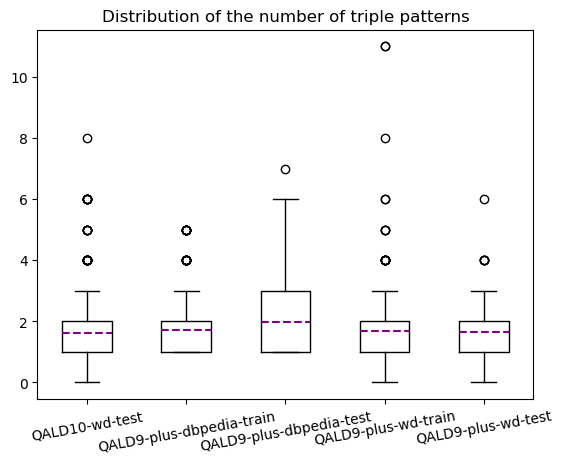

In [61]:
columns = [dist_triple_patterns_qald10_wikidata_test, dist_triple_patterns_qald9_dbpedia_train, dist_triple_patterns_qald9_dbpedia_test, dist_triple_patterns_qald9_wikidata_train, dist_triple_patterns_qald9_wikidata_test]
title = "Distribution of the number of triple patterns"
plot_box(columns, xticks, title)

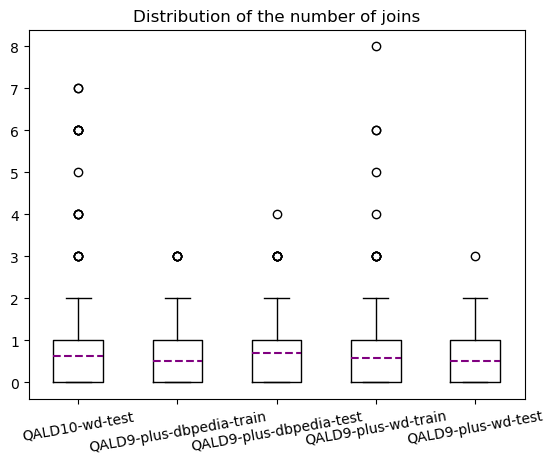

In [62]:
columns = [dist_joins_qald10_wikidata_test, dist_joins_qald9_dbpedia_train, dist_joins_qald9_dbpedia_test, dist_joins_qald9_wikidata_train, dist_joins_qald9_wikidata_test]
title = "Distribution of the number of joins"
plot_box(columns, xticks, title)

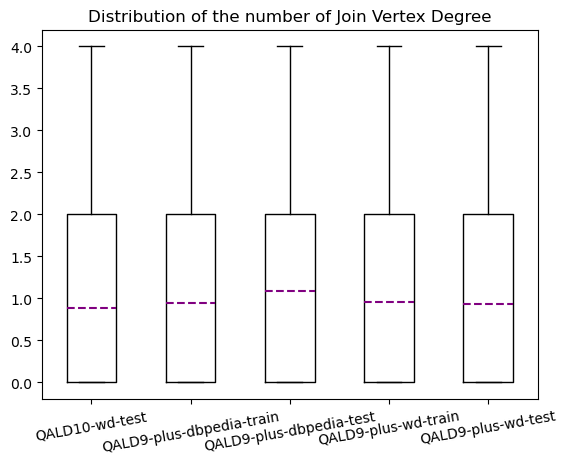

In [63]:
columns = [dist_jvd_qald10_wikidata_test, dist_jvd_qald9_dbpedia_train, dist_jvd_qald9_dbpedia_test, dist_jvd_qald9_wikidata_train, dist_jvd_qald9_wikidata_test]
title = "Distribution of the number of Join Vertex Degree"
plot_box(columns, xticks, title)